In [102]:
import SimpleITK as sitk
import numpy as np
import csv
import os
import cv2
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
def load_itk_image(filename):
    itkimage = sitk.ReadImage(filename)
    numpyImage = sitk.GetArrayFromImage(itkimage)
     
    numpyOrigin = np.array(list(reversed(itkimage.GetOrigin())))
    numpySpacing = np.array(list(reversed(itkimage.GetSpacing())))
     
    return numpyImage, numpyOrigin, numpySpacing

In [8]:
def readCSV(filename):
    lines = []
    with open(filename, "rb") as f:
        csvreader = csv.reader(f)
        for line in csvreader:
            lines.append(line)
    return lines

In [9]:
def worldToVoxelCoord(worldCoord, origin, spacing):
     
    stretchedVoxelCoord = np.absolute(worldCoord - origin)
    voxelCoord = stretchedVoxelCoord / spacing
    return voxelCoord

In [10]:
def normalizePlanes(npzarray):
     
    maxHU = 400.
    minHU = -1000.
 
    npzarray = (npzarray - minHU) / (maxHU - minHU)
    npzarray[npzarray>1] = 1.
    npzarray[npzarray<0] = 0.
    return npzarray

In [109]:
def grays_to_RGB(img):
    # turn 2D grayscale image into grayscale RGB
    return np.dstack((img, img, img))



def image_with_mask(img, mask,color=(0,255,0)):
    maximg=np.max(img)    
    img=np.asarray(img,dtype='float32')
    img=np.asarray((img/maximg)*255,dtype='uint8')
    mask=np.asarray(mask,dtype='uint8') 
    if np.max(mask)==1:
        mask=mask*255

    # returns a copy of the image with edges of the mask added in red
    if len(img.shape)==2:	
	img_color = grays_to_RGB(img)
    else:
	img_color =img

    mask_edges = cv2.Canny(mask, 100, 200) > 0
    img_color[mask_edges, 0] = maximg*color[0]  # set channel 0 to bright red, green & blue channels to 0
    img_color[mask_edges, 1] = maximg*color[1]
    img_color[mask_edges, 2] = maximg*color[2]
    img_color=img_color#/float(np.max(img))
    return img_color

def normalize(image):
    ####### normalization
    MIN_BOUND = -1000.0
    MAX_BOUND = 400.0
    
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image>1] = 1.
    image[image<0] = 0.
    return image


In [ ]:
## read sample luna data and its lung segmentation

In [89]:
import ntpath

path2lungsegs='/media/mra/win71/data/misc/kaggle/datascience2017/LUNA2016/seg-lungs-LUNA16/'
path2lunadata='/media/mra/My Passport/Kaggle/datascience2017/hpz440/LUNA2016/subset0/'

datalist1=glob(path2lungsegs+'*.mhd')
datalist2=glob(path2lunadata+'*.mhd')
print len(datalist1)
print len(datalist2)

img_path1=datalist2[0] 
base1=ntpath.basename(img_path1)
img_path2=path2lungsegs+base1
print img_path1
print img_path2

# load image
X, numpyOrigin, numpySpacing = load_itk_image(img_path1)
Y, numpyOrigin, numpySpacing = load_itk_image(img_path2)
print Y.shape
print X.shape

print np.min(Y),np.max(Y)
print np.min(X),np.max(X)

print numpyOrigin
print numpySpacing

888
89
/media/mra/My Passport/Kaggle/datascience2017/hpz440/LUNA2016/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.277445975068759205899107114231.mhd
/media/mra/win71/data/misc/kaggle/datascience2017/LUNA2016/seg-lungs-LUNA16/1.3.6.1.4.1.14519.5.2.1.6279.6001.277445975068759205899107114231.mhd
(177, 512, 512)
(177, 512, 512)
0 5
-1024 3071
[-342.8        -330.62890625 -174.62890625]
[ 1.79999995  0.7421875   0.7421875 ]


107


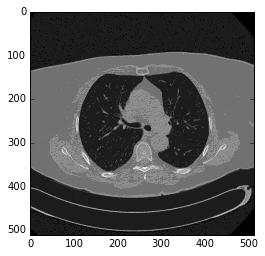

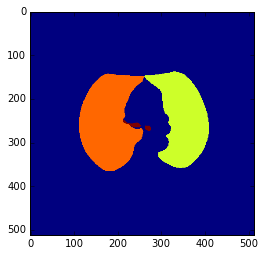

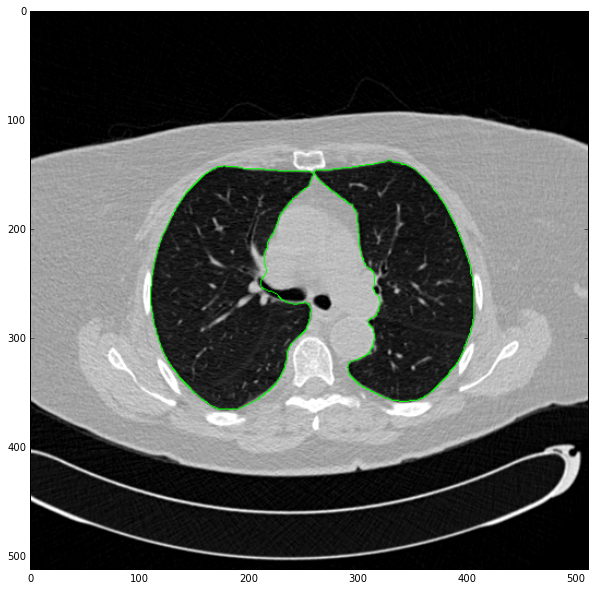

In [240]:
n1=np.random.randint(len(X))
print n1
plt.imshow(X[n1]/255,cmap='gray')
plt.show()

plt.imshow(Y[n1])
plt.show()

Y1=(Y[n1]==4) | (Y[n1]==3) 
XY1=image_with_mask(normalize(X[n1]),Y1)

plt.figure(figsize=(10,10))
plt.imshow(XY1)
plt.show()


In [154]:
import scipy.ndimage
def resample(image, spacing, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    #spacing = np.array([scan[0].SliceThickness] + scan[0].PixelSpacing, dtype=np.float32)
    
    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    #new_spacing = spacing / real_resize_factor
     
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    return image#, new_spacing

In [155]:
Xr=resample(X,numpySpacing)
print Xr.shape


(319, 380, 380)


In [523]:
Ylung=(Y==4) | (Y==3)
Yr=resample(np.array(Ylung,'uint8'),numpySpacing)>0
print Yr.shape
print np.min(Yr),np.max(Yr)

(319, 380, 380)
False True


bool
60
0.0 0.836428571429


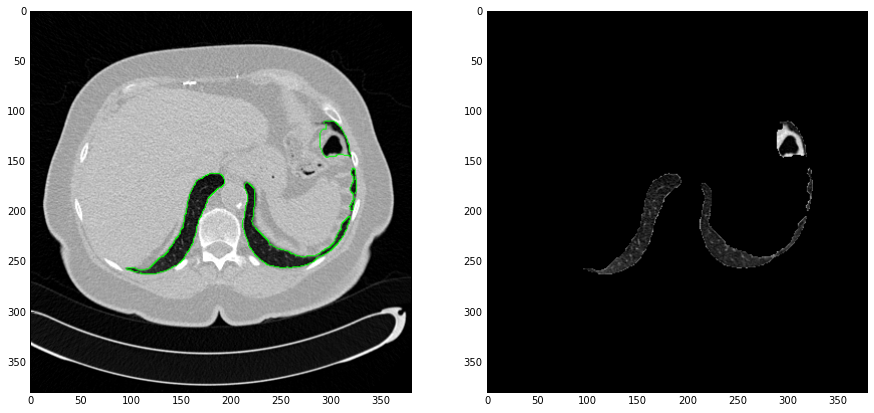

In [524]:
print Ylung.dtype
n1=np.random.randint(len(X))
print n1

Y1=np.array(Yr[n1],'uint8')
XY1=image_with_mask(normalize(Xr[n1]),Y1)

#Y2=(Y[n1]==4) | (Y[n1]==3)
X2=normalize(Xr[n1])
XY2=X2*Yr[n1]
#XY2=np.asarray(XY2*(2**15-1),'int16')
#XY2=image_with_mask(XY2*255,Yr[n1])
print np.min(XY2),np.max(XY2)

plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(XY1)

plt.subplot(1,2,2)
plt.imshow(XY2,cmap='gray')

plt.show()

In [330]:
import pandas as pd
# read annotations csv
path2annotations='/media/mra/win71/data/misc/kaggle/datascience2017/LUNA2016/evaluationScript/annotations/annotations_excluded.csv'

df_node = pd.read_csv(path2annotations)
print 'dataset size:', len(df_node["seriesuid"])
mylist = list(set(df_node["seriesuid"]))
print 'sample series id:', mylist[0]
df_node.head()




dataset size: 35192
sample series id: 1.3.6.1.4.1.14519.5.2.1.6279.6001.262736997975960398949912434623


,seriesuid,coordX,coordY,coordZ,diameter_mm
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-131.896495,-155.056702,-317.8,-1.0
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,80.798735,-109.295000,-123.4,-1.0
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-62.287146,-55.154396,-283.6,-1.0
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,83.376859,-58.377052,-236.8,-1.0
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-41.017623,-60.310644,-240.4,-1.0


# voxel coordinates in resampling

In [528]:
import h5py

def worldToVoxelCoord(worldCoord, origin, spacing):
     
    stretchedVoxelCoord = np.absolute(worldCoord - origin)
    voxelCoord = stretchedVoxelCoord / spacing
    
    return voxelCoord

def resample_vCord(voxelCoord, spacing, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    
    resize_factor = spacing / new_spacing
    new_voxelCoord = voxelCoord * resize_factor
    new_voxelCoord = np.round(new_voxelCoord).astype('uint16')
    #real_resize_factor = new_shape / voxelCoord
    #new_spacing = spacing / real_resize_factor
    return new_voxelCoord

# spacing file
path2spacing='/media/mra/win71/data/misc/kaggle/datascience2017/LUNA2016/subset0_spacing.hdf5'
ff_spacing=h5py.File(path2spacing,'r')
print 'total keys:', len(ff_spacing.keys())

for key in ff_spacing.keys():
    mini_df = df_node[df_node["seriesuid"]==key[:-4]] #get all nodules associate with file
    print key[:-4]
    for node_idx, cur_row in mini_df.iterrows():       
        node_x = cur_row["coordX"]
        node_y = cur_row["coordY"]
        node_z = cur_row["coordZ"]
        diam = cur_row["diameter_mm"]
        worldCoord=[node_z,node_y,node_x]
        #print node_x,node_y,node_z,diam
        spacing=ff_spacing[key]['spacing'].value
        origin=ff_spacing[key]['origin'].value
        #voxelCoord=worldToVoxelCoord(worldCoord,origin,spacing)
        voxelCoord=np.round(worldToVoxelCoord(worldCoord, origin, spacing)).astype('uint16')
        if diam>0:
            print 'diam,voxel,resample:', diam,voxelCoord,resample_vCord(voxelCoord,spacing)
    print '-'*50

total keys: 89
1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260
diam,voxel,resample: 4.905760503 [ 77 290 307] [192 221 234]
diam,voxel,resample: 5.03225838 [ 55 317  86] [138 241  66]
diam,voxel,resample: 5.174086155 [ 77 290 307] [192 221 234]
diam,voxel,resample: 4.314955493 [ 84 287  75] [210 219  57]
diam,voxel,resample: 4.637434851 [ 88 267 390] [220 203 297]
--------------------------------------------------
1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492
diam,voxel,resample: 5.783211732 [ 33 347 111] [ 82 258  82]
diam,voxel,resample: 5.116966663 [ 33 346 110] [ 82 257  82]
diam,voxel,resample: 5.217402407 [ 33 346 110] [ 82 257  82]
--------------------------------------------------
1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059
diam,voxel,resample: 3.656769684 [ 97 268 103] [121 147  57]
diam,voxel,resample: 13.68703562 [ 68 285 426] [ 85 156 234]
diam,voxel,resample: 4.239974637 [132 293 379] [165 161 208]
diam,voxel,resampl

total keys 67 67
32 1.3.6.1.4.1.14519.5.2.1.6279.6001.295298571102631191572192562523.mhd
voxel,resample: 5.670119985 [ 66 229 118] [ 82 161  83]
voxel,resample: 5.737666252 [ 66 229 118] [ 82 161  83]
voxel,resample: 6.454015941 [111 243 391] [139 171 275]
voxel,resample: 5.421299654 [ 66 229 118] [ 82 161  83]
voxel,resample: 6.086065366 [111 243 391] [139 171 275]
(2, 232, 512, 512)
(array([ 65,  66,  67, 109, 110, 111]),)


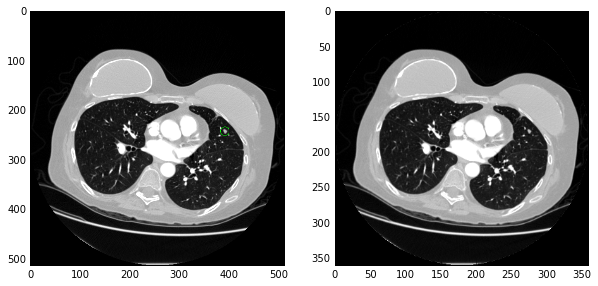

In [476]:
# read images and nodes from subset
path2subsets="/media/mra/My Passport/Kaggle/datascience2017/hpz440/LUNA2016/hdf5/"
path2subsets_rescale="/media/mra/win71/data/misc/kaggle/datascience2017/LUNA2016/"
path2s0=path2subsets+"subset0.hdf5"
path2s0_rescale=path2subsets_rescale+"subset0_rescale.hdf5"

# read subset file
ff_s0=h5py.File(path2s0,'r')
ff_s0_rescake=h5py.File(path2s0_rescale,'r')

# reading keys/ids
keys=ff_s0.keys()
keys_r=ff_s0.keys()
print 'total keys', len(keys),len(keys_r)


# pick a random id
rnd_id=np.random.randint(len(keys))
key=keys[rnd_id]
print rnd_id, key

# reading nodules coordinates
mini_df = df_node[df_node["seriesuid"]==key[:-4]] #get all nodules associate with file
spacing=ff_spacing[key]['spacing'].value
origin=ff_spacing[key]['origin'].value

for node_idx, cur_row in mini_df.iterrows():       
    node_x = cur_row["coordX"]
    node_y = cur_row["coordY"]
    node_z = cur_row["coordZ"]
    diam = cur_row["diameter_mm"]
    worldCoord=[node_z,node_y,node_x]
    #voxelCoord=worldToVoxelCoord(worldCoord,origin,spacing)
    if diam>0:
        voxelCoord=np.round(worldToVoxelCoord(worldCoord, origin, spacing)).astype('uint16')
        re_voxelCoord=resample_vCord(voxelCoord,spacing)
        #print origin,spacing
        #print 'diam,world:', diam,worldCoord
        print 'voxel,resample:',diam,voxelCoord,re_voxelCoord


XY=ff_s0[key]
print XY.shape

X1=XY[0,:]
Y1=XY[1,:]
sumY=np.sum(Y1,axis=(1,2))
print np.where(sumY>0)

n1=voxelCoord[0]
XY1=image_with_mask(normalize(X1[n1]),Y1[n1])
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(XY1)


# rescaled image
Xr1=ff_s0_rescake[key]
n1=re_voxelCoord[0]
plt.subplot(1,2,2)
plt.imshow(normalize(Xr1[n1]),cmap='gray')
plt.show()



# crop nodule from original data

(232, 512, 512)
[111 243 391]
0
1
2
[ 79 211 359] [143 275 423]
(64, 64, 64)


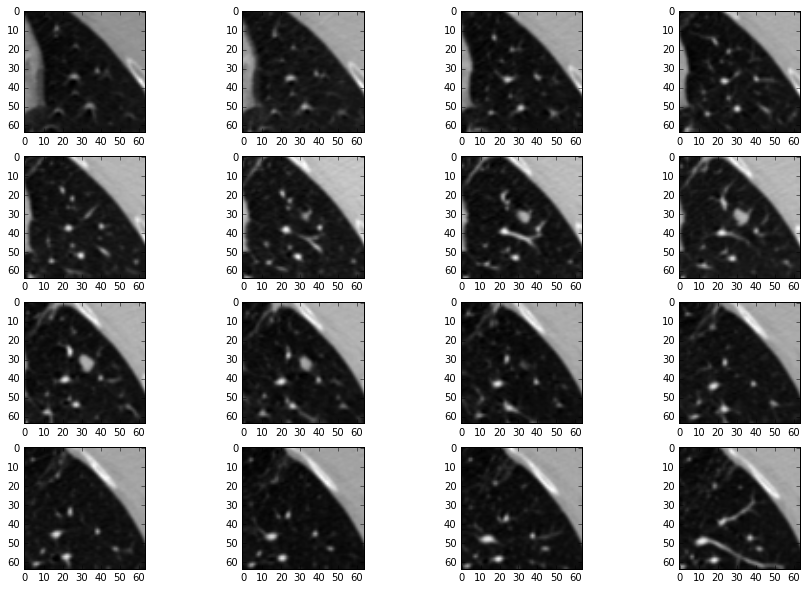

In [477]:
print X1.shape
w=32
print voxelCoord

Z,H,W=X1.shape
z,y,x=voxelCoord

zyx_1 = voxelCoord - w # Attention: Z, Y, X
zyx_2 = voxelCoord + w 

for k in range(3):
    print k
    if zyx_1[k]<0:
        zyx_1[k]=0
        zyx_2[k]=2*w
    if zyx_2[k]>X1.shape[k]:
        zyx_1[k]=X1.shape[k]-2*w
        zyx_2[k]=X1.shape[k]       
print zyx_1,zyx_2    
    
# crop 2w*2w*2w
Xc1 = X1[ zyx_1[0]:zyx_2[0], zyx_1[1]:zyx_2[1], zyx_1[2]:zyx_2[2] ]

print Xc1.shape    
plt.figure(figsize=(15,10))    
for k in range(16):    
    plt.subplot(4,4,k+1)    
    plt.imshow(Xc1[24+k],cmap='gray')

# crop from resample data

(290, 360, 360)
[139 171 275]
0
1
2
[107 139 243] [171 203 307]
(64, 64, 64)


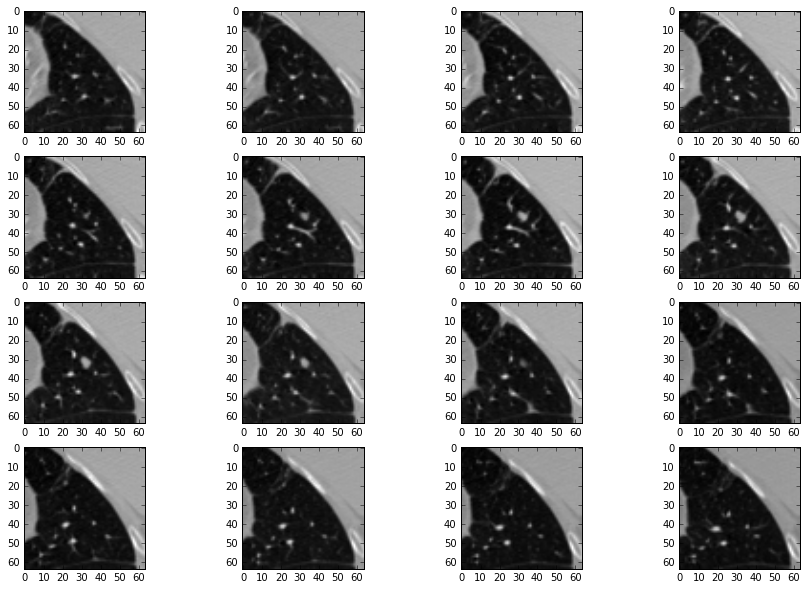

In [478]:
print Xr1.shape
w=32
print re_voxelCoord

Z,H,W=Xr1.shape
z,y,x=re_voxelCoord

zyx_1 = re_voxelCoord - w # Attention: Z, Y, X
zyx_2 = re_voxelCoord + w 

for k in range(3):
    print k
    if zyx_1[k]<0:
        zyx_1[k]=0
        zyx_2[k]=2*w
    if zyx_2[k]>Xr1.shape[k]:
        zyx_1[k]=Xr1.shape[k]-2*w
        zyx_2[k]=Xr1.shape[k]       
print zyx_1,zyx_2    
    
# crop 2w*2w*2w
Xc1 = Xr1[ zyx_1[0]:zyx_2[0], zyx_1[1]:zyx_2[1], zyx_1[2]:zyx_2[2] ]

print Xc1.shape    
plt.figure(figsize=(15,10))    
for k in range(16):    
    plt.subplot(4,4,k+1)    
    plt.imshow(Xc1[24+k],cmap='gray')

## rescaled data

total keys 67 67
55 1.3.6.1.4.1.14519.5.2.1.6279.6001.621916089407825046337959219998.mhd
voxel,resample: 11.19113834 [ 81 307 147] [202 264 126]
voxel,resample: 11.47495273 [ 81 307 147] [202 264 126]
voxel,resample: 11.49726909 [ 81 307 147] [202 264 126]
(2, 133, 512, 512)
(133, 512, 512)
(332, 440, 440)
min max type 0 5 uint8
non-zeros: (array([80, 81, 82]),)
min max X: -2484 3981
min max X: 0 1 uint8
min max X: 0.0 1.0


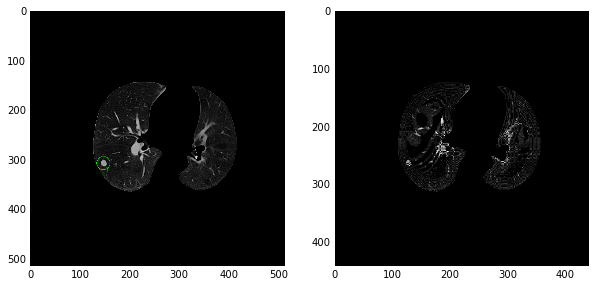

In [527]:

# read images and nodes from subset
path2subsets="/media/mra/My Passport/Kaggle/datascience2017/hpz440/LUNA2016/hdf5/"
path2subsets_rescale="/media/mra/win71/data/misc/kaggle/datascience2017/LUNA2016/"
path2s0=path2subsets+"subset0.hdf5"
path2s0_rescale=path2subsets_rescale+"subset0_rescale.hdf5"
path2s0_lung=path2subsets_rescale+"subset0_lung.hdf5"
path2s0_lung_rescale=path2subsets_rescale+"subset0_lung_rescale.hdf5"


# read subset file
ff_s0=h5py.File(path2s0,'r')
ff_s0_rescake=h5py.File(path2s0_rescale,'r')
ff_s0_lung=h5py.File(path2s0_lung,'r')
ff_s0_lung_rescale=h5py.File(path2s0_lung_rescale,'r')


# reading keys/ids
keys=ff_s0.keys()
keys_r=ff_s0.keys()
print 'total keys', len(keys),len(keys_r)


# pick a random id
rnd_id=np.random.randint(len(keys))
key=keys[rnd_id]
print rnd_id, key

# reading nodules coordinates
mini_df = df_node[df_node["seriesuid"]==key[:-4]] #get all nodules associate with file
spacing=ff_spacing[key]['spacing'].value
origin=ff_spacing[key]['origin'].value

for node_idx, cur_row in mini_df.iterrows():       
    node_x = cur_row["coordX"]
    node_y = cur_row["coordY"]
    node_z = cur_row["coordZ"]
    diam = cur_row["diameter_mm"]
    worldCoord=[node_z,node_y,node_x]
    #voxelCoord=worldToVoxelCoord(worldCoord,origin,spacing)
    if diam>0:
        voxelCoord=np.round(worldToVoxelCoord(worldCoord, origin, spacing)).astype('uint16')
        re_voxelCoord=resample_vCord(voxelCoord,spacing)
        #print origin,spacing
        #print 'diam,world:', diam,worldCoord
        print 'voxel,resample:',diam,voxelCoord,re_voxelCoord


# original data
XY=ff_s0[key]
print XY.shape

X_lung=ff_s0_lung[key]
X_lung_r=ff_s0_lung_rescale[key]
print X_lung.shape
print X_lung_r.shape

n1=voxelCoord[0]

# image and nodule
X1=XY[0,:][n1]
# normalize
X1=normalize(X1)*X_lung[n1]
print 'min max type', np.min(X_lung[n1]),np.max(X_lung[n1]),X_lung[n1].dtype

# nodule
Y1=XY[1,:]
sumY=np.sum(Y1,axis=(1,2))
print 'non-zeros:', np.where(sumY>0)


XY1=image_with_mask(X1,Y1[n1])
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(XY1)


# rescaled image
n1=re_voxelCoord[0]
Xr1=ff_s0_rescake[key]
print 'min max X:', np.min(Xr1),np.max(Xr1)
Xr1=normalize(Xr1[n1])*X_lung_r[n1]

print 'min max X:', np.min(X_lung_r[n1]),np.max(X_lung_r[n1]),X_lung_r.dtype
print 'min max X:', np.min(Xr1),np.max(Xr1)
plt.subplot(1,2,2)
plt.imshow(Xr1,cmap='gray')
plt.show()


